In [1]:
import numpy as np
import os
from CoPhaser import utils
from CoPhaser import plotting
import sys

sys.path.insert(0, "../set_up")  # add set_up path to search list

import plot_helpers
import constants

from scipy.stats import pearsonr
from scipy.sparse import csr_matrix, hstack, vstack

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

import anndata
import scanpy as sc
import pickle
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DATA_FOLDER = "../figure_3/data/"
SCRNASEQ_DATA_FOLDER = "../../../data/"

height_ratios_scaling: [1, 1, 1, 1]


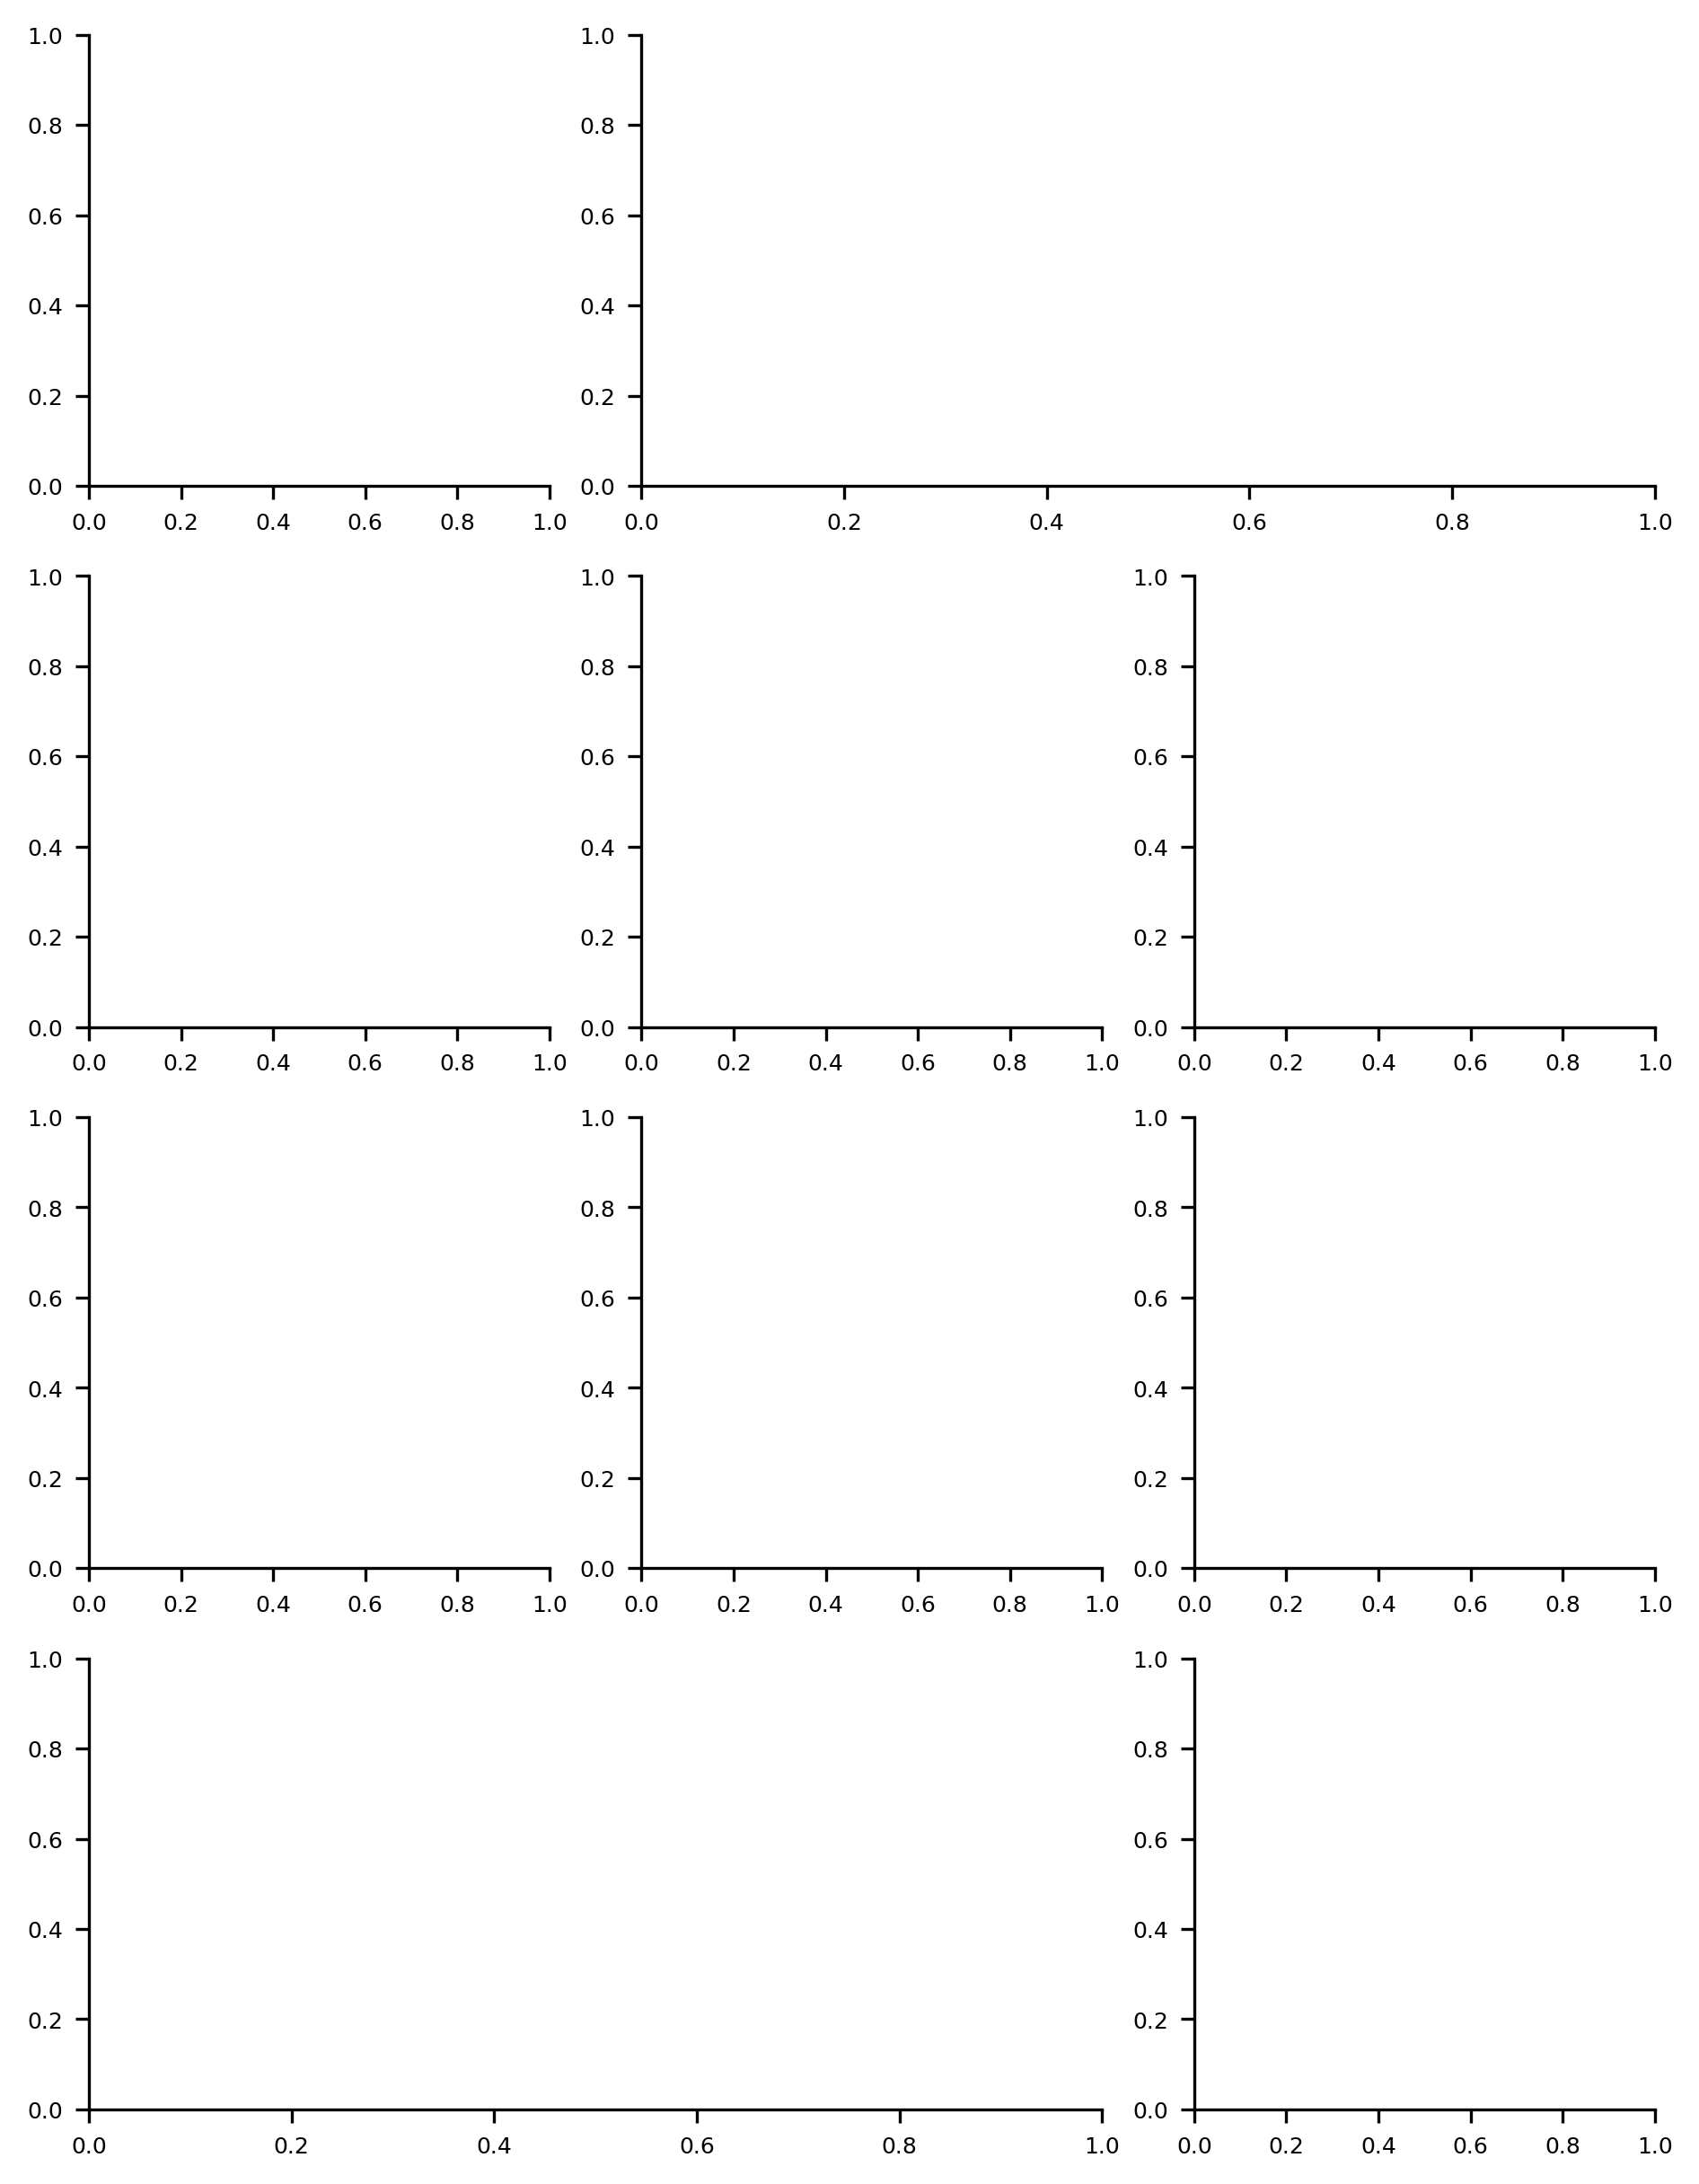

In [4]:
mosaic = [["A", "B", "B"], ["C", "D", "E"], ["F", "G", "H"], ["I", "I", "J"]]
fig, axs = plot_helpers.create_pannels(mosaic=mosaic, h_pad=0)

In [5]:
breast_cancer = pickle.load(
    open(os.path.join(DATA_FOLDER, "breast_cancer_results.pkl"), "rb")
)
breast_cancer

{'z_space_embedding': array([[ 13.453772  ,   1.8798009 ],
        [ 15.209827  ,   1.0762023 ],
        [ 14.123289  ,   0.51939666],
        ...,
        [ -9.553252  ,  -2.6086369 ],
        [ -9.898246  ,  -3.035167  ],
        [-10.406434  ,  -2.9625492 ]], dtype=float32),
 'inferred_theta': array([ 0.15582252,  0.29155588,  1.3966305 , ..., -1.2312727 ,
        -1.3223536 , -1.6453419 ], dtype=float32),
 'cycling_cells': array([ True,  True,  True, ..., False,  True, False]),
 'latent_z': array([[ 0.37332025,  2.5333421 , -0.46433154, ...,  1.718476  ,
         -0.9878677 , -0.3008021 ],
        [ 0.85030633,  3.3389647 , -1.3104458 , ...,  1.7666677 ,
         -0.95434105,  0.33655956],
        [ 0.8152305 ,  3.4553273 , -0.7615098 , ...,  1.5899904 ,
         -1.4149601 ,  0.08895269],
        ...,
        [ 0.59145766,  2.1623764 , -1.5544022 , ...,  1.7311082 ,
          0.08773069,  2.0144174 ],
        [ 0.13439658,  2.4320266 , -1.5418478 , ...,  1.6831615 ,
         -0.68

In [6]:
adata = breast_cancer["adata"]

In [7]:
def get_gene_fractions(gene_name, adata, layer="total"):
    library_size = adata.layers[layer].sum(axis=1)
    library_size = np.array(library_size).flatten()
    gene_fractions = (
        adata[:, gene_name].layers[layer].toarray().flatten() / library_size
    )
    return gene_fractions


def plot_gene_profiles(
    gene_names,
    adata,
    inferred_phase,
    axs,
    position,
    GT_phase=None,
    layer="total",
    hue=None,
    phase_label="Inferred",
    legend_title=None,
):
    axs = plot_helpers.replace_mosaic_cell_with_grid(
        fig, axs, label=position, nrows=1, ncols=len(gene_names)
    )
    for i in range(len(gene_names)):
        gene_name = gene_names[i]
        gene_fractions = get_gene_fractions(gene_name, adata, layer=layer)
        _, axs[position][i] = plotting.modify_axis_labels(
            ax=axs[position][i], axis="x", step=0.5
        )
        plotting.plot_smoothed_profiles(
            inferred_phase,
            np.log(gene_fractions * 1e4 + 1),
            ax=axs[position][i],
            nbins=20,
            xlabel="Inferred Phase",
            ylabel=f"Normalized Counts (log)" if i == 0 else None,
            label=(
                phase_label
                if (i == len(gene_names) - 1 and GT_phase is not None)
                else None
            ),
            legend=i == len(gene_names) - 1,
            hue=hue,
        )
        axs[position][i].set_title(f"{gene_name}", fontweight="bold", style="italic")
        if i == len(gene_names) - 1 and legend_title is not None:
            axs[position][i].legend(title=legend_title)

In [8]:
ax = axs["A"]
plotting.plot_z_space_paper(
    breast_cancer["z_space_embedding"][:, 0],
    breast_cancer["z_space_embedding"][:, 1],
    ax=ax,
    alpha=0.7,
    hue=adata.obs["group"],
    xlabel="UMAP 1",
    ylabel="UMAP 2",
    legend=False,
)
ax.legend(title="Patient")

/tmp/ipykernel_1539082/4043092997.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Patient")


In [9]:
cycling_status = breast_cancer["cycling_cells"]
plot_gene_profiles(
    ["MCM6", "PCNA", "TOP2A"],
    adata[cycling_status],
    breast_cancer["inferred_theta"][cycling_status],
    axs,
    position="B",
    hue=adata.obs["orig.ident"][cycling_status],
    legend_title="Subtype",
)

In [10]:
ax = axs["C"]
plotting.modify_axis_labels(ax=ax, step=0.5)
# plot library size

library_size = adata.layers["total"].sum(axis=1).A1
plotting.plot_smoothed_profiles(
    x=utils.normalize_angles(breast_cancer["inferred_theta"][cycling_status]),
    y=library_size[cycling_status],
    ax=ax,
    xlabel="Inferred Phase",
    ylabel="Mean #UMI",
    title="#UMI vs Inferred Phase",
    hue=adata.obs["orig.ident"][cycling_status],
)
ax.legend(title="Subtype")

In [11]:
gene = "UBE2C"
ax = axs["D"]
sns.barplot(
    hue=adata.obs["orig.ident"],
    y=np.log(get_gene_fractions(gene, adata) * 1e4 + 1),
    ax=ax,
    errorbar=None,
)
ax.set_title(f"{gene}", fontweight="bold", style="italic")
ax.set_ylabel("Normalized Counts (log)")
ax.set_xlabel("Subtype")
ax.legend(title="Subtype")
ax = axs["E"]
plotting.modify_axis_labels(ax=ax, step=0.5, offset=np.pi)
plotting.plot_smoothed_profiles(
    utils.normalize_angles(breast_cancer["inferred_theta"][cycling_status] - np.pi)
    + np.pi,
    np.log(get_gene_fractions(gene, adata[cycling_status]) * 1e4 + 1),
    ax=ax,
    nbins=20,
    xlabel="Inferred Phase",
    ylabel=f"Normalized Counts (log)",
    title=f"",
    hue=adata[cycling_status].obs["orig.ident"].values,
)
ax.set_title(f"{gene}", fontweight="bold", style="italic")
ax.legend(title="Subtype")

In [12]:
pediatric_aml = pickle.load(open(os.path.join(DATA_FOLDER, "pediatric_AML.pkl"), "rb"))
pediatric_aml

{'z_space_embedding': array([[ 2.5561152 , -6.481769  ],
        [16.331743  , 11.699138  ],
        [-0.52440226, -4.93733   ],
        ...,
        [15.640232  , -2.6159835 ],
        [-3.6016643 , -4.126458  ],
        [ 8.069708  ,  8.384726  ]], dtype=float32),
 'inferred_theta': array([-3.0396245, -2.4219258, -2.0254095, ..., -2.2524426, -2.3294318,
        -2.251279 ], dtype=float32),
 'cycling_cells': array([False, False, False, ..., False, False, False]),
 'latent_z': array([[-0.8631499 , -1.4890265 ,  1.7039591 , ...,  0.5811543 ,
          0.3291146 ,  0.15435264],
        [-0.27354324, -0.8837525 , -0.69724053, ..., -2.1305141 ,
          0.93229663, -1.392461  ],
        [ 0.869895  , -0.79457694,  0.18148074, ...,  1.9572536 ,
          0.5817861 ,  0.57708806],
        ...,
        [-1.7820222 ,  0.6504992 ,  0.6586789 , ..., -0.5621695 ,
         -2.040071  , -2.996825  ],
        [-0.00645644,  2.856797  ,  0.58965904, ...,  2.7201688 ,
         -0.48885024, -0.6901364

In [13]:
ax = axs["F"]
adata = pediatric_aml["adata"]
random_sampling_points = adata.obs.sample(n=10000, random_state=42)
# transform to mask
random_sampling_mask = adata.obs.index.isin(random_sampling_points.index)
plotting.plot_z_space_paper(
    pediatric_aml["z_space_embedding"][random_sampling_mask, 0],
    pediatric_aml["z_space_embedding"][random_sampling_mask, 1],
    ax=ax,
    alpha=0.8,
    hue=adata[random_sampling_mask].obs["Lambo_et_al_ID"],
    xlabel="UMAP 1",
    ylabel="UMAP 2",
    legend=False,
    size=5,
)
ax.legend(title="Patient ID")

/tmp/ipykernel_1539082/2874842146.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Patient ID")


In [14]:
ax = axs["H"]
adata = pediatric_aml["adata"]
plotting.plot_z_space_paper(
    pediatric_aml["z_space_embedding"][random_sampling_mask, 0],
    pediatric_aml["z_space_embedding"][random_sampling_mask, 1],
    ax=ax,
    alpha=0.8,
    hue=adata[random_sampling_mask].obs["Classified_Celltype"],
    xlabel="UMAP 1",
    ylabel="UMAP 2",
    legend=False,
    size=5,
)
ax.legend(title="Classified Celltype")

/tmp/ipykernel_1539082/1412604926.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Classified Celltype")


In [15]:
ax = axs["G"]
adata = pediatric_aml["adata"]
plotting.plot_z_space_paper(
    pediatric_aml["z_space_embedding"][random_sampling_mask, 0],
    pediatric_aml["z_space_embedding"][random_sampling_mask, 1],
    ax=ax,
    alpha=0.8,
    hue=adata[random_sampling_mask].obs["Malignant"],
    xlabel="UMAP 1",
    ylabel="UMAP 2",
    legend=True,
    size=5,
)

In [16]:
ax = axs["H"]
adata = pediatric_aml["adata"]
plotting.plot_z_space_paper(
    pediatric_aml["z_space_embedding"][random_sampling_mask, 0],
    pediatric_aml["z_space_embedding"][random_sampling_mask, 1],
    ax=ax,
    alpha=0.8,
    hue=adata[random_sampling_mask].obs["Classified_Celltype"],
    xlabel="UMAP 1",
    ylabel="UMAP 2",
    legend=False,
    size=5,
)
ax.legend(title="Classified Celltype")

/tmp/ipykernel_1539082/1412604926.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Classified Celltype")


In [17]:
ax = axs["J"]
plotting.modify_axis_labels(ax=ax, step=0.5)
# plot library size
i = pediatric_aml["cycling_cells"] & (adata.obs["Malignant"] == "Malignant")
library_size = adata.layers["total"].sum(axis=1).A1
hue_order = adata.obs["Subgroup"][i].astype(str).unique()
hue_order = np.sort(hue_order)
plotting.plot_smoothed_profiles(
    x=utils.normalize_angles(pediatric_aml["inferred_theta"][i]),
    y=library_size[i],
    ax=ax,
    xlabel="Inferred Phase",
    ylabel="Mean #UMI",
    title="#UMI vs Inferred Phase",
    add_end_start_points=True,
    hue=adata.obs["Subgroup"][i].astype(str).values,
    hue_order=hue_order,
)
ax.legend(title="Subgroup")

In [18]:
plot_gene_profiles(
    ["MCM6", "PCNA", "TOP2A"],
    adata,
    pediatric_aml["inferred_theta"],
    axs,
    position="I",
    hue=adata.obs["Subgroup"],
    legend_title="Subgroup",
)

Figure saved to: /home/maxine/Documents/paychere/cell_cycle_VAE_Fourrier_model/paper/figures/figure_S6_cancer.svg


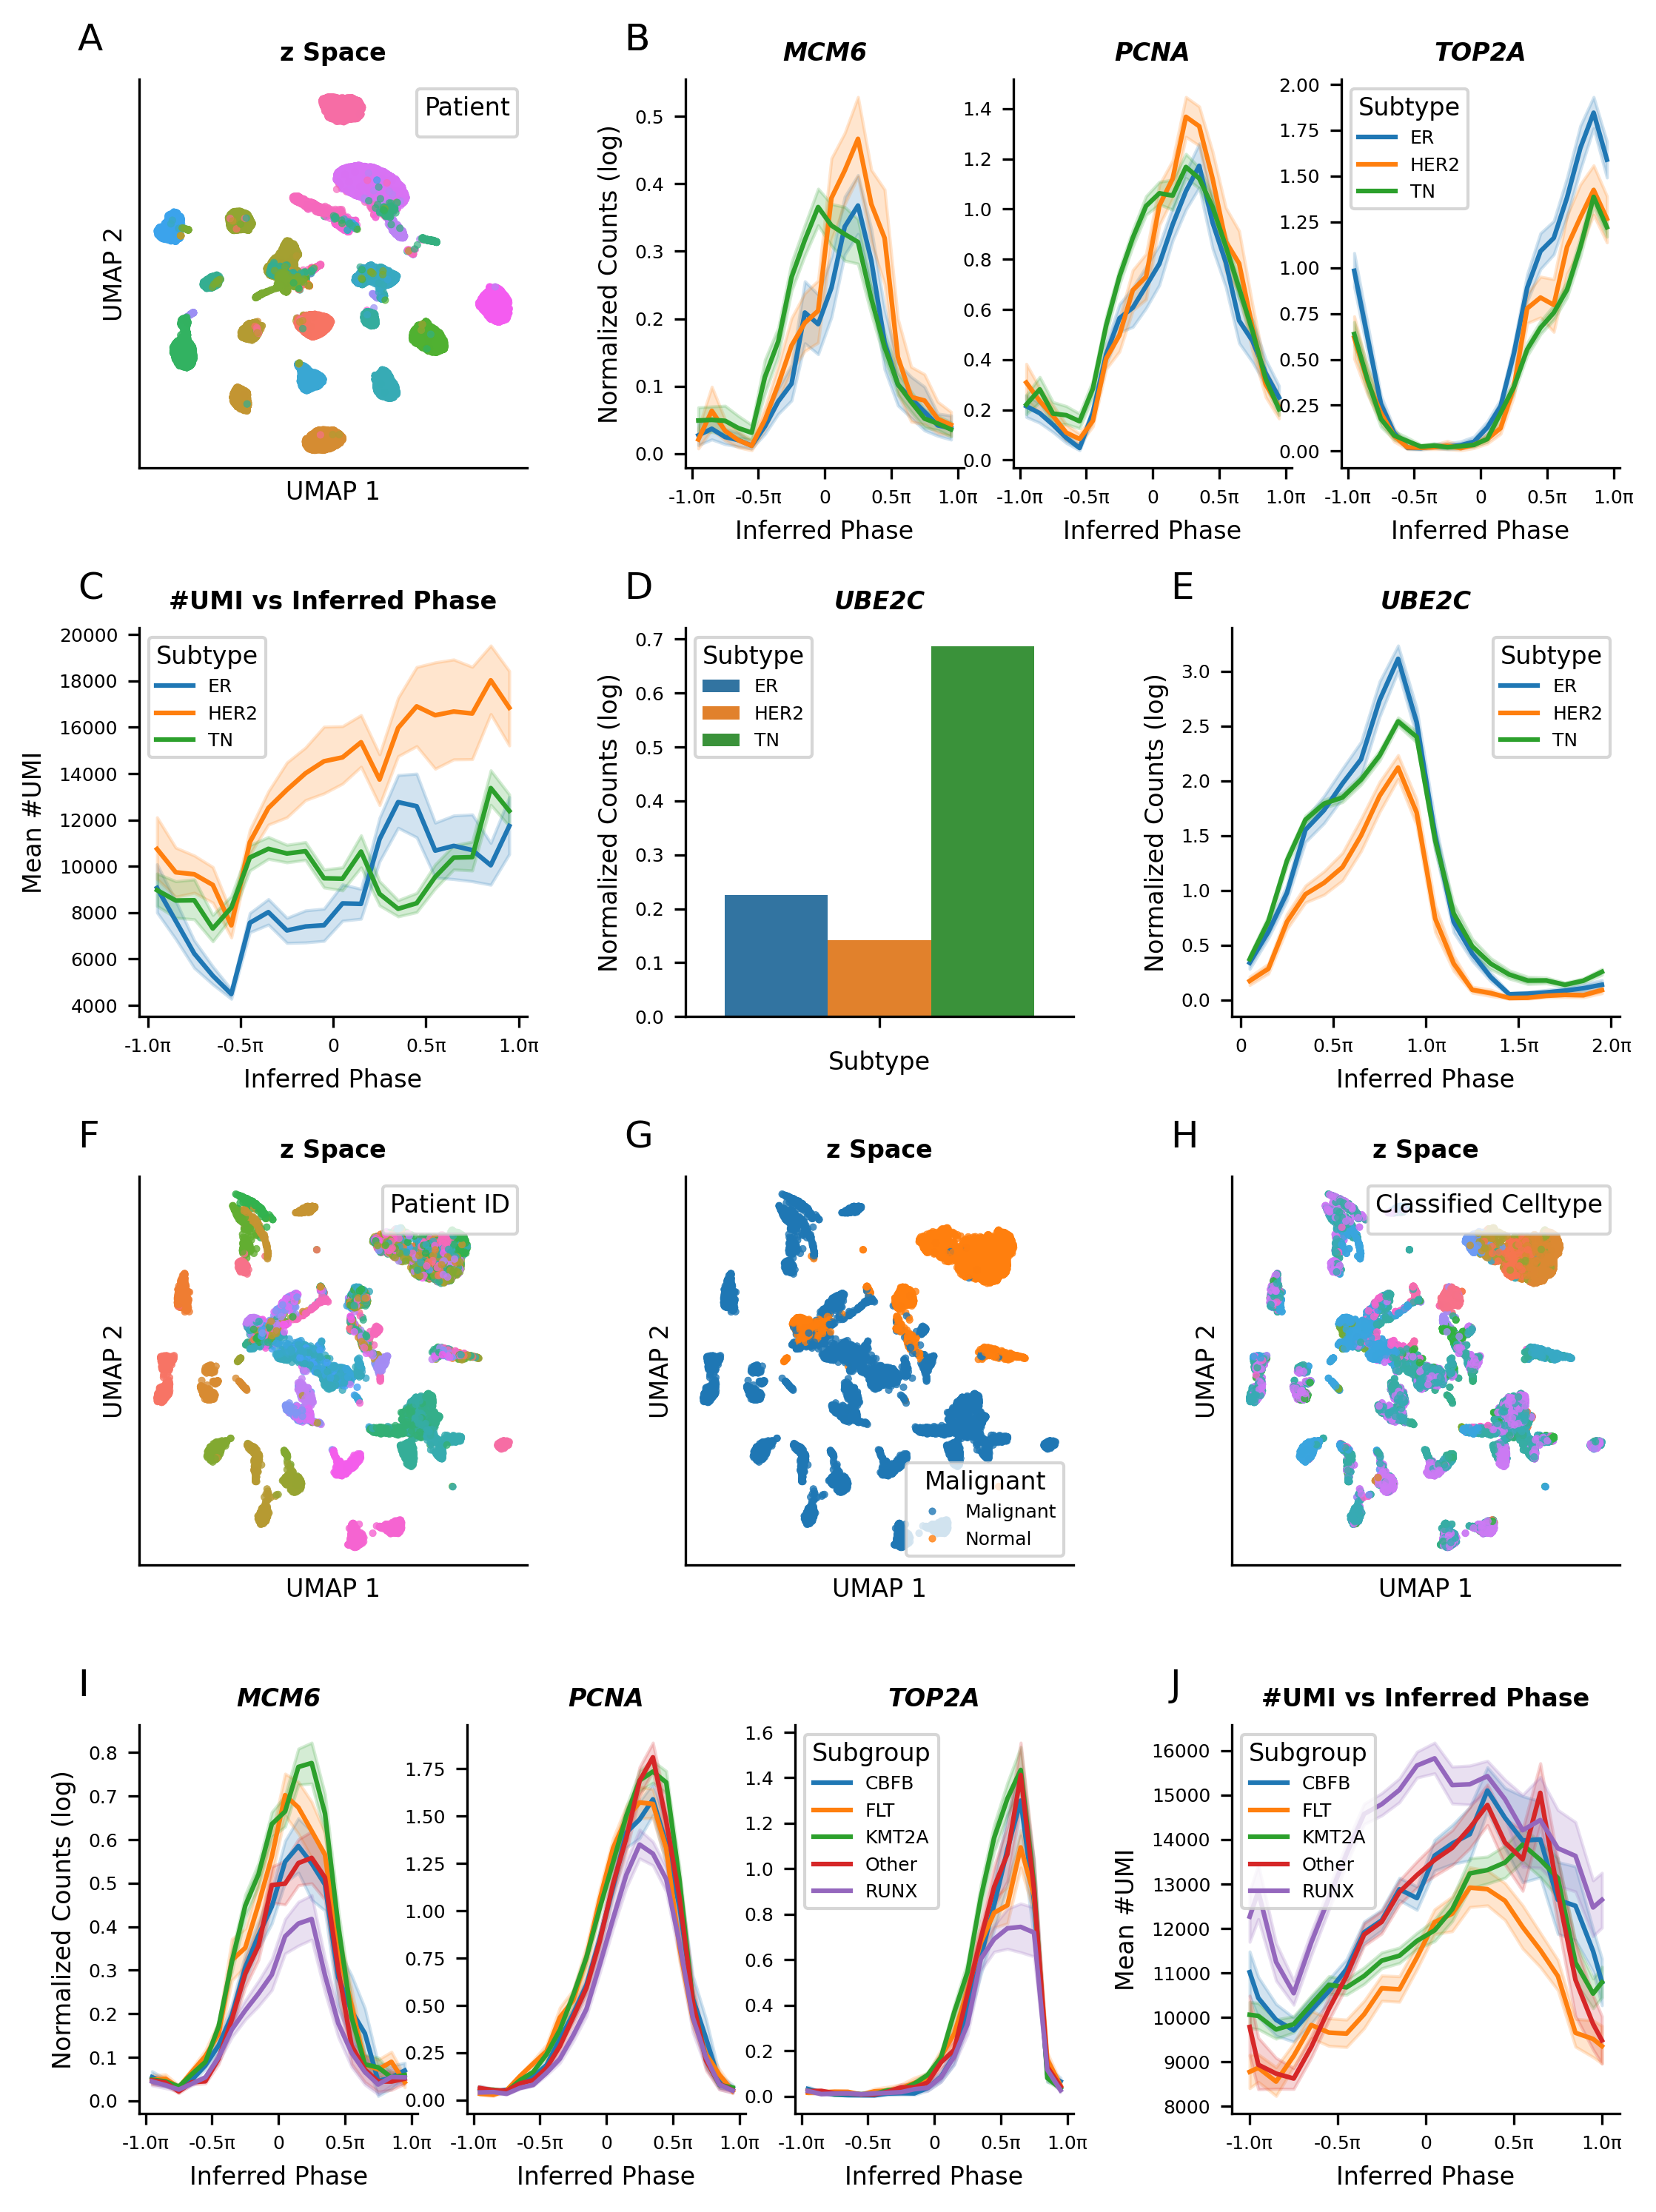

In [19]:
plot_helpers.label_panels_mosaic(fig, axs, mosaic)
plot_helpers.save_figure(fig, axs, "figure_S6_cancer")